In [1]:
%load_ext nb_black
# !pip install nb_black
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier
from thundersvm import SVC as svmgpu
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, SMOTENC  # doctest: +NORMALIZE_WHITESPACE

# from multiscorer import MultiScorer
from sklearn.model_selection import cross_val_score
from numpy import average
import xgboost as xgb
from sklearn import metrics as m
import itertools

<IPython.core.display.Javascript object>

In [3]:
randomseed = 7
np.random.seed(randomseed)

<IPython.core.display.Javascript object>

In [4]:
data = pd.read_csv("pima-indians-diabetes.csv")
print(data.shape)

(768, 9)


<IPython.core.display.Javascript object>

In [5]:
data.isnull().values.any()

False

<IPython.core.display.Javascript object>

In [6]:
nan_value = float("NaN")

data.replace("", nan_value, inplace=True)


<IPython.core.display.Javascript object>

In [7]:
data = data.apply(pd.to_numeric, errors="coerce")
data = data.dropna()
print(data.shape)
data.head(100)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
95,6,144,72,27,228,33.9,0.255,40,0
96,2,92,62,28,0,31.6,0.130,24,0
97,1,71,48,18,76,20.4,0.323,22,0
98,6,93,50,30,64,28.7,0.356,23,0


<IPython.core.display.Javascript object>

In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

x=data.iloc[:,:-1]
y=data.iloc[:,-1]

xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=randomseed,test_size=0.2)


<IPython.core.display.Javascript object>

In [9]:
from sklearn.ensemble import RandomForestClassifier

<IPython.core.display.Javascript object>

In [10]:
from sklearn.base import clone


def drop_col_feat_imp(model, X_train, y_train, random_state=42):

    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []

    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis=1), y_train)
        importances.append(benchmark_score - drop_col_score)

    importances_df = imp_df(X_train.columns, importances)
    return importances_df

<IPython.core.display.Javascript object>

In [11]:
rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)

<IPython.core.display.Javascript object>

In [12]:
from sklearn.base import clone


def imp_df(column_names, importances):
    df = (
        pd.DataFrame({"feature": column_names, "feature_importance": importances})
        #         .sort_values("feature_importance", ascending=False)
        #         .reset_index(drop=True)
    )
    return df


def drop_col_feat_imp(model, X_train, y_train, xtest, ytest, random_state=42):

    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(xtest, ytest)
    benchmark_featureimportance = model_clone.feature_importances_

    print(benchmark_score)
    # list for storing feature importances
    importances = []

    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        print(col)
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(xtest.drop(col, axis=1), ytest)
        importances.append(benchmark_score - drop_col_score)
        print(benchmark_score - drop_col_score, drop_col_score)

    importances_df = imp_df(X_train.columns, importances)
    return importances_df, benchmark_score, benchmark_featureimportance

<IPython.core.display.Javascript object>

In [13]:
pd.DataFrame(xtest, columns=data.columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
353,1,90,62,12,43,27.2,0.580,24,NaN
236,7,181,84,21,192,35.9,0.586,51,NaN
323,13,152,90,33,29,26.8,0.731,43,NaN
98,6,93,50,30,64,28.7,0.356,23,NaN
701,6,125,78,31,0,27.6,0.565,49,NaN
...,...,...,...,...,...,...,...,...,...
153,1,153,82,42,485,40.6,0.687,23,NaN
392,1,131,64,14,415,23.7,0.389,21,NaN
308,0,128,68,19,180,30.5,1.391,25,NaN
70,2,100,66,20,90,32.9,0.867,28,NaN


<IPython.core.display.Javascript object>

In [14]:
importances_df, benchmark_score, benchmark_featureimportance = drop_col_feat_imp(
    rf,
    pd.DataFrame(xtrain, columns=data.columns[:-1]),
    ytrain,
    pd.DataFrame(xtest, columns=data.columns[:-1]),
    ytest,
    randomseed,
)

0.7597402597402597
Pregnancies
-0.019480519480519543 0.7792207792207793
 Glucose
0.038961038961038974 0.7207792207792207
 BloodPressure
-0.038961038961038974 0.7987012987012987
 SkinThickness
-0.032467532467532534 0.7922077922077922
 Insulin
-0.025974025974025983 0.7857142857142857
 BMI
-0.012987012987012991 0.7727272727272727
 DiabetesPedigreeFunction
0.0 0.7597402597402597
 Age
-0.019480519480519543 0.7792207792207793


<IPython.core.display.Javascript object>

In [16]:
Finalvalue = pd.DataFrame()
Finalvalue["features"] = data.columns[:-1]
Finalvalue["benchmark_featureimportance"] = benchmark_featureimportance
Finalvalue["importances_df"] = -importances_df.feature_importance
Finalvalue["newScore"] = benchmark_score - importances_df.feature_importance
Finalvalue = Finalvalue.sort_values(
    by="benchmark_featureimportance", ascending=False
).reset_index(drop=True)

<IPython.core.display.Javascript object>

<BarContainer object of 8 artists>

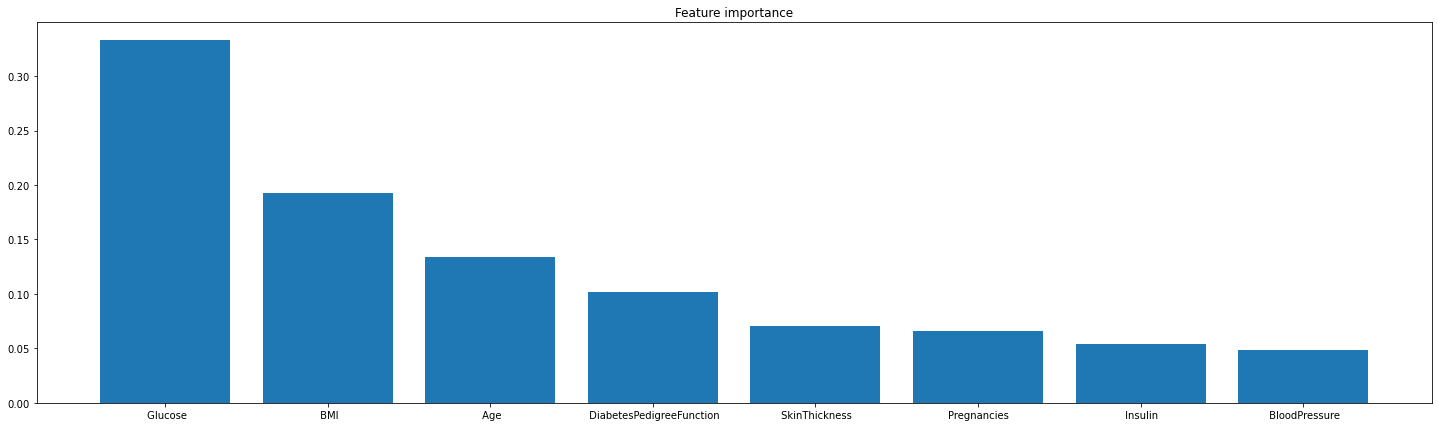

<IPython.core.display.Javascript object>

In [17]:
plt.rcParams["figure.figsize"] = (25, 7)
plt.title("Feature importance")
plt.bar(Finalvalue.features, Finalvalue.benchmark_featureimportance)

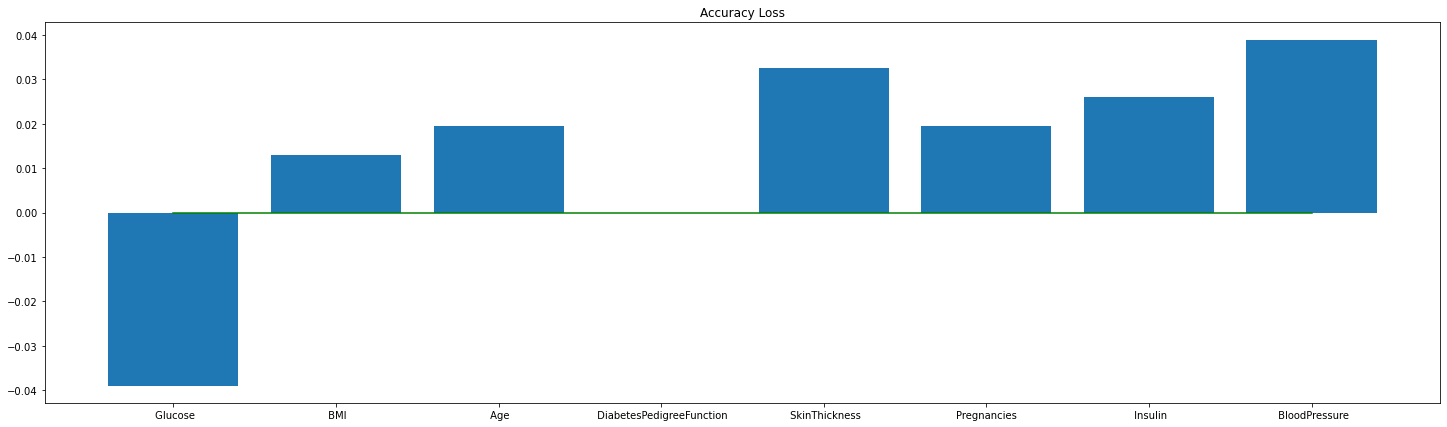

<IPython.core.display.Javascript object>

In [18]:
plt.bar(Finalvalue.features, Finalvalue.importances_df)
plt.title("Accuracy Loss")
plt.plot(
    Finalvalue.features, np.full((len(Finalvalue.features), 1), 0.0), color="green"
)

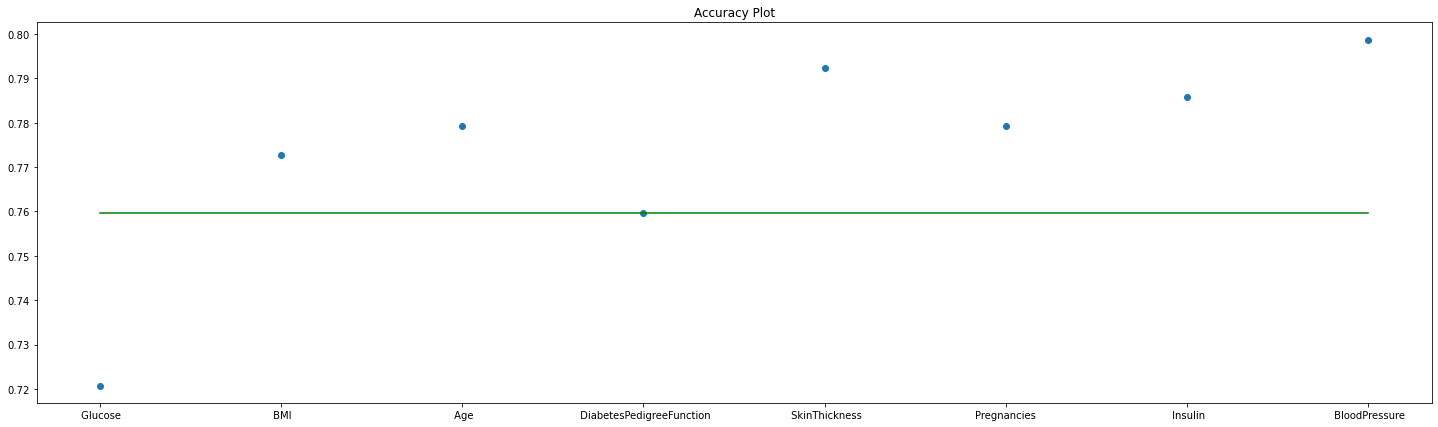

<IPython.core.display.Javascript object>

In [19]:
plt.scatter(Finalvalue.features, Finalvalue.newScore)
plt.title("Accuracy Plot")
plt.plot(
    Finalvalue.features,
    np.full((len(Finalvalue.features), 1), benchmark_score),
    color="green",
)

In [20]:
Finalvalue

,features,benchmark_featureimportance,importances_df,newScore
0,Glucose,0.332733,-0.038961,0.720779
1,BMI,0.192810,0.012987,0.772727
2,Age,0.133792,0.019481,0.779221
3,DiabetesPedigreeFunction,0.101691,-0.000000,0.759740
4,SkinThickness,0.070545,0.032468,0.792208
5,Pregnancies,0.065699,0.019481,0.779221
6,Insulin,0.054351,0.025974,0.785714
7,BloodPressure,0.048380,0.038961,0.798701


<IPython.core.display.Javascript object>

In [25]:
data.iloc[:, 1:2]

,Glucose
0,148
1,85
2,183
3,89
4,137
...,...
763,101
764,122
765,121
766,126


<IPython.core.display.Javascript object>

In [30]:
rf.fit(xtrain.iloc[:, 1:2], ytrain)
print(rf.score(xtest.iloc[:, 1:2], ytest))

0.7337662337662337


<IPython.core.display.Javascript object>